# Tourist Accommodations Data

**Objective**  
This part is dedicated to Data Wrangling and EDA of tourist accommodation dataset.

**Description and characteristics of dataset**  
Tourist rental property listings on major platforms.

The characteristics of this dataset are as follows:
- Estimated volume: 25,000 records every 7 days
- Historical data: Available from 2017-01

**Data description**  
[Data description](https://datamarket.es/#alojamientos-turisticos-dataset)  
[Data overview (number of non missing values, unique, missing values)](https://github.com/ITACADEMYprojectes/ProjecteData/blob/main/Equip_F/Data/data_overview.xlsx)

In [1]:
# import libraries 
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
# font sizes
plt.rcParams['figure.titlesize'] = 18 
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14             
plt.rcParams['axes.labelsize'] = 14  

plt.rcParams['xtick.labelsize'] = 12      
plt.rcParams['ytick.labelsize'] = 12       
plt.rcParams['legend.fontsize'] = 12

# display settings
#pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
 
# set palette
sns.set_palette('Paired')

sns.set_style("darkgrid")

<div class="alert alert-info"> 
<b>Comment</b> 

We can use any other color palette if you like more other colors =)
    
</div>

In [3]:
# Check versions of libraries
def lib_versions(libs):
    for lib in libs: print('Version', lib.__name__, '-', lib.__version__)

lib_versions([np, pd, mpl, sns])

Version numpy - 2.2.1
Version pandas - 2.2.3
Version matplotlib - 3.10.0
Version seaborn - 0.13.2


## Data Loading

In [4]:
PATH = 'Data'
SPRINT = 1
filename = f'data_sprint_{SPRINT}.csv'

In [5]:
# define function to read file
def read_file(sprint):
    
    """Input: number of sprint.
    Function reads .csv data of desired sprint. 
    Output: Dataframe or error.
    """
    
    # reading file
    try:
        df = pd.read_csv(os.path.join('..', PATH, filename), 
                         parse_dates=['insert_date', 'first_review_date', 'last_review_date'], 
                         date_format='%d/%m/%Y')
        display(df.head())
        return df
    except Exception as error:
        print("An exception occurred:", error)
        return error     

In [6]:
df = read_file(filename)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
0,11964,A ROOM WITH A VIEW,Private bedroom in our attic apartment. Right ...,45553,Centro,NaN,Private room,2,2.00,1.00,1.00,"TV,Internet,Wifi,Air conditioning,Elevator,Buz...",400.00,3,365,VERDADERO,7,20,40,130,78,2010-01-02,2017-09-05,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,75.00,spain,malaga,2018-07-31
1,21853,Bright and airy room,We have a quiet and sunny room with a good vie...,83531,C�rmenes,Latina,Private room,1,1.00,1.00,1.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Free...",170.00,4,40,VERDADERO,0,0,0,162,33,2014-10-10,2018-07-15,920.00,90.00,90.00,100.00,100.00,80.00,90.00,FALSO,52.00,spain,madrid,2020-01-10
2,32347,Explore Cultural Sights from a Family-Friendly...,Open French doors and step onto a plant-filled...,139939,San Vicente,Casco Antiguo,Entire home/apt,4,1.00,2.00,2.00,"TV,Internet,Wifi,Air conditioning,Wheelchair a...",990.00,2,120,VERDADERO,26,31,31,270,148,2011-01-05,2019-07-22,980.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,142.00,spain,sevilla,2019-07-29
3,35379,Double 02 CasanovaRooms Barcelona,Room at a my apartment. Kitchen and 2 bathroom...,152232,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,2.00,1.00,1.00,"TV,Internet,Wifi,Kitchen,Breakfast,Elevator,Bu...",400.00,2,730,VERDADERO,9,23,49,300,292,2012-03-13,2020-01-04,940.00,100.00,90.00,100.00,100.00,100.00,90.00,VERDADERO,306.00,spain,barcelona,2020-01-10
4,35801,Can Torras Farmhouse Studio Suite,Lay in bed & watch sunlight change the mood of...,153805,Quart,NaN,Private room,5,1.00,2.00,5.00,"Wifi,Pool,Free parking on premises,Breakfast,P...",900.00,1,180,VERDADERO,0,19,49,312,36,2011-07-08,2018-08-08,970.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,39.00,spain,girona,2019-02-19


## Data Overview

In [7]:
# define function to display information about the data
def data_info(df):
   
    """Input: dataframe.
    Function displays basic information, 
    checks for duplicates and NaN. 
    """
    
    # get information about the data
    print(df.info())
    
    # number of unique values for each column
    print()
    print('\033[1mNumber of unique values')
    display(df.nunique())

    # check for NaN
    if df.isna().sum().sum() > 0:
        print()
        print('\033[1mNumber of missing values')
        display(
            pd.DataFrame({'number': df.isna().sum(), 
                          'percentage': df.isna().mean().mul(100)})
            .query('number > 0')
            .sort_values(by='number', ascending=False)
        )
    else:
        print('There are no NaNs in the data\n')
    
    # check for duplicates (without id columns)
    print()
    if df.iloc[:,1:].duplicated().sum() > 0:
        print('Data contain full duplicates\n')
    else:
        print('There are no full duplicates in the data\n')

In [8]:
data_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 7001 non-null   int64         
 1   name                         6998 non-null   object        
 2   description                  6972 non-null   object        
 3   host_id                      7001 non-null   int64         
 4   neighbourhood_name           7001 non-null   object        
 5   neighbourhood_district       4241 non-null   object        
 6   room_type                    7001 non-null   object        
 7   accommodates                 7001 non-null   int64         
 8   bathrooms                    6969 non-null   float64       
 9   bedrooms                     6972 non-null   float64       
 10  beds                         6998 non-null   float64       
 11  amenities_list               6984 non-null 

apartment_id                   6733
name                           6755
description                    6790
host_id                        5239
neighbourhood_name              478
neighbourhood_district           61
room_type                         4
accommodates                     19
bathrooms                        13
bedrooms                         14
beds                             22
amenities_list                 6792
price                           383
minimum_nights                   38
maximum_nights                  129
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               319
first_review_date              1793
last_review_date               1459
review_scores_rating             45
review_scores_accuracy            9
review_scores_cleanliness         8
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,2760,39.42
review_scores_value,1342,19.17
review_scores_location,1342,19.17
review_scores_checkin,1341,19.15
review_scores_accuracy,1336,19.08
review_scores_communication,1332,19.03
review_scores_cleanliness,1330,19.00
review_scores_rating,1327,18.95
last_review_date,1255,17.93
first_review_date,1254,17.91



There are no full duplicates in the data



In [9]:
df.country.unique(), df.city.unique()

(array(['spain'], dtype=object),
 array(['malaga', 'madrid', 'sevilla', 'barcelona', 'girona', 'valencia',
        'mallorca', 'menorca'], dtype=object))


---

The dataset contains 7,001 rows and 35 columns.  
The unique values in country and city confirm that the dataset focuses on Spain, covering six cities—'Malaga', 'Madrid', 'Sevilla', 'Barcelona', 'Girona', and 'Valencia'—as well as two islands: 'Mallorca' and 'Menorca'.

*Missing Values*
- 130 rows lack a `price` value.
- The `neighbourhood_district` column has 2,760 missing values (~39% of the data).
- Review-related columns have between 1,250 and 1,327 missing values.
- 550 rows are missing `has_availability` information.

*Duplicates*
- 268 duplicate values in `apartment_id`.
- 243 duplicate values in `name`.
- 182 duplicate values in `description`.
- 192 duplicate values in `amenities_list`.

*Text format issues*  
The presence of � (replacement characters) in string columns is likely due to incorrect encoding, which prevents proper display of special characters (e.g., Spanish accents: á, é, í, ó, ú, ñ).

**Conclusion**  
Before performing an exhaustive EDA, several data quality issues need to be addressed:  
*Missing Values*
- The missing `price` values should be investigated, as they directly impact the marketing business task.
- NaN values in `has_availability` can be treated as 'False', and depending on the business needs, these rows may be dropped.
- Missing values in other columns are not critical for Sprint_1 and do not affect KPIs.

*Duplicates*  
Duplicate apartment_id, name, and description should be analyzed. It's unusual for different apartments to have the same descriptions, which may indicate data inconsistencies or incorrect entries.

## Duplicates

First, let's handle duplicates—removing them might also eliminate listings with missing prices.

In [10]:
print('Number of objects with 1 or more duplicates')
(df['apartment_id'].value_counts()>1).sum()

Number of objects with 1 or more duplicates


np.int64(261)

In [11]:
df['apartment_id'].value_counts().head(20)

apartment_id
10713417    3
13966456    3
14582385    3
15402794    3
14326808    3
10005342    3
24038577    3
16592689    2
15885378    2
14662418    2
27245117    2
11520183    2
2797209     2
8858054     2
6397577     2
3942375     2
16378860    2
16140518    2
16384978    2
13359409    2
Name: count, dtype: int64

In [12]:
df[df.apartment_id==10713417]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1989,10713417,Room in the heart of barcelona,Room in the center of barcelona just 2 minutes...,2456260,"Sant Pere, Santa Caterina i la Ribera",Ciutat Vella,Private room,1,1.00,1.00,1.00,"Wifi,Kitchen,Smoking allowed,Pets allowed,Door...",370.00,2,1125,VERDADERO,0,0,7,282,68,2016-03-02,2018-09-30,960.00,100.00,90.00,100.00,100.00,100.00,100.00,VERDADERO,214.00,spain,barcelona,2018-10-10
1990,10713417,Room in the heart of barcelona,Room in the center of barcelona just 2 minutes...,2456260,"Sant Pere, Santa Caterina i la Ribera",Ciutat Vella,Private room,1,1.00,1.00,1.00,"Wifi,Kitchen,Smoking allowed,Pets allowed,Door...",370.00,2,1125,VERDADERO,26,56,86,355,72,2016-03-02,2019-01-20,960.00,100.00,90.00,100.00,100.00,100.00,100.00,FALSO,196.00,spain,barcelona,2019-03-08
1991,10713417,Room in the heart of barcelona,Room in the center of barcelona just 2 minutes...,2456260,"Sant Pere, Santa Caterina i la Ribera",Ciutat Vella,Private room,1,1.00,1.00,1.00,"Wireless Internet,Kitchen,Smoking allowed,Pets...",330.00,1,1125,VERDADERO,0,0,30,305,27,2016-03-02,2017-09-08,950.00,100.00,90.00,100.00,100.00,100.00,100.00,FALSO,138.00,spain,barcelona,2017-10-07


Some objects with the same `apartment_id` have 1 or even 2 duplicates recorded on different `insert_date` values. Let's check whether they also share the same name and location, as it's possible for different properties to have the same name but be in different places.

In [13]:
res = (df[df['apartment_id'].duplicated(keep=False)]
       .groupby('apartment_id')[['name', 'description', 'room_type', 'host_id', 'city', 'insert_date']]
       .nunique())

res

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
144471,1,1,1,1,1,2
157327,1,1,1,1,1,2
343864,1,1,1,1,1,2
503253,1,1,1,1,1,2
886569,1,2,1,1,1,2
...,...,...,...,...,...,...
26546841,1,0,1,1,1,2
26889462,1,1,1,1,1,2
26987062,1,0,1,1,1,2


In [14]:
res[res.insert_date<2]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always have different `insert_date` → We can keep the most recent entry.

In [15]:
res[res.city>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,


`apartment_id` duplicates always belong to the same city → This supports the idea that they are actual duplicates rather than different properties.

In [16]:
res[res.room_type>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
14288527,1,2,2,1,1,2
18682379,2,2,2,1,1,2
24342447,1,1,2,1,1,2


In [17]:
df[df.apartment_id.isin(res[res.room_type>1].index)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
2861,14288527,"Great penthouse with terrace, overlooking the sea",-The accommodation meets the Sanitary Cleaning...,34433429,Centro,NaN,Entire home/apt,2,1.00,1.00,1.00,"Free street parking, Garden or backyard, Iron,...",670.00,2,31,VERDADERO,19,49,79,160,237,2016-08-10,2020-10-12,970.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,443.00,spain,malaga,2020-12-30
2862,14288527,"Great penthouse with terrace, overlooking the sea","Great penthouse with terrace, overlooking the ...",34433429,Este,NaN,Private room,2,1.00,1.00,1.00,"TV,Internet,Wireless Internet,Pool,Free parkin...",440.00,2,15,VERDADERO,14,18,40,41,102,2016-08-10,2017-11-21,970.00,100.00,100.00,100.00,100.00,90.00,100.00,VERDADERO,647.00,spain,malaga,2017-11-25
4238,18682379,"Lush, sunny & quiet 2 bedroom apartment",Search no more! Welcome to your spacious 2 bed...,27775148,la Dreta de l'Eixample,Eixample,Entire home/apt,4,1.00,2.00,2.00,"Wifi,Kitchen,Breakfast,Elevator,Family/kid fri...",2750.00,4,60,VERDADERO,0,8,8,14,8,2017-07-18,2019-01-01,1000.00,100.00,100.00,100.00,100.00,100.00,90.00,FALSO,44.00,spain,barcelona,2019-01-14
4239,18682379,"Lush, sunny & quiet 2ble room in Barcelona center",Search no more! Welcome to your spacious doubl...,27775148,la Dreta de l'Eixample,Eixample,Private room,2,1.00,1.00,1.00,"Wireless Internet,Kitchen,Breakfast,Elevator,F...",650.00,2,20,VERDADERO,0,0,13,288,4,2017-07-18,2017-08-18,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,146.00,spain,barcelona,2017-10-07
6262,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Hotel room,4,NaN,1.00,4.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Pets...",2000.00,1,1125,VERDADERO,0,16,46,160,8,2018-08-04,2019-10-23,900.00,90.00,90.00,100.00,100.00,100.00,90.00,VERDADERO,34.00,spain,barcelona,2020-07-17
6263,24342447,Suite Apt 4 pax en Sants,Apartamento con capacidad para 4 personas con ...,3346610,Sants,Sants-Montju�c,Entire home/apt,4,1.00,1.00,2.00,"Internet,Wifi,Air conditioning,Free parking on...",1650.00,1,1125,VERDADERO,28,58,88,215,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,barcelona,2018-07-10


In [18]:
res[res.host_id>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
19196593,2,2,1,2,1,2


In [19]:
df.query('apartment_id==19196593')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4492,19196593,"Centro 4 con garaje gratis, 1 dormitorio",Apartamento de 1 dormitorio con garaje incluid...,18077486,Cruz De Humilladero,NaN,Entire home/apt,4,1.00,1.00,3.00,"Free street parking, Iron, Washer, Hot water, ...",500.00,2,1125,VERDADERO,0,0,0,213,42,2017-06-27,2020-09-05,930.00,100.00,90.00,100.00,100.00,90.00,90.00,VERDADERO,98.00,spain,malaga,2020-12-30
4493,19196593,"CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723","Supermercado Mercadona a 1 minuto, tiendas y b...",134286611,Bailen-Miraflores,NaN,Entire home/apt,4,1.00,1.00,3.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",500.00,2,1125,VERDADERO,0,0,0,181,29,2017-06-27,2018-09-30,940.00,100.00,90.00,100.00,100.00,90.00,90.00,VERDADERO,16.00,spain,malaga,2018-12-22


In [20]:
df.query('apartment_id==19196593')['name']

4492             Centro 4 con garaje gratis, 1 dormitorio
4493    CENTRO 4 CON GARAJE GRATIS, APARTAM. VFT/MA/13723
Name: name, dtype: object

<div class="alert alert-info"> 
<b>Comment</b> 

Here I am not sure, different districts (but they are touching), but very similar info.
    
</div>

In [21]:
res[res.name>1]

,name,description,room_type,host_id,city,insert_date
apartment_id,,,,,,
1624014,2,2,1,1,1,2
3163230,2,2,1,1,1,2
3634997,2,2,1,1,1,2
3770072,2,2,1,1,1,2
6584564,2,2,1,1,1,2
7029540,2,1,1,1,1,2
9619438,2,2,1,1,1,2
10806296,2,1,1,1,1,2
12514998,2,2,1,1,1,2


In [22]:
ap_id_dupl_name = res[(res.name>1) & (res.description>1) & (res.host_id<2)].index

In [23]:
df[df.apartment_id.isin(ap_id_dupl_name)]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
470,1624014,Beautiful apartment to Enjoy the real Barcelona,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,3.00,5.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",1600.00,3,90,VERDADERO,16,46,76,334,141,2014-04-14,2020-01-06,910.00,90.00,90.00,100.00,100.00,90.00,90.00,VERDADERO,198.00,spain,barcelona,2020-02-16
471,1624014,Brand-New Low Priced Large Apt 6p,Recently refurbished modern and spacious 3 bed...,1260560,la Nova Esquerra de l'Eixample,Eixample,Entire home/apt,6,2.00,3.00,5.00,"TV,Cable TV,Internet,Wireless Internet,Air con...",1870.00,3,1125,NaN,0,17,47,322,51,2014-04-14,2016-12-04,890.00,90.00,90.00,90.00,90.00,90.00,90.00,VERDADERO,153.00,spain,barcelona,2017-01-04
758,3163230,Apartment in Sagrada Familia for 4 - WIFI,Bel appartement � 100 m de La Sagrada Familia....,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1.00,2.00,3.00,"Dedicated workspace, Oven, Cooking basics, Dis...",600.00,15,330,VERDADERO,1,31,61,336,39,2014-06-16,2019-10-10,860.00,90.00,90.00,90.00,100.00,90.00,90.00,FALSO,49.00,spain,barcelona,2021-01-12
759,3163230,PISO PARA 5 EN SAGRADA FAMILIA,Piso muy lindo y comodo que puede acoger hasta...,8811801,la Sagrada Fam�lia,Eixample,Entire home/apt,5,1.00,2.00,3.00,"TV,Wireless Internet,Kitchen,Elevator in build...",900.00,7,365,NaN,0,0,0,196,38,2014-06-16,2017-05-18,860.00,90.00,90.00,90.00,100.00,90.00,90.00,VERDADERO,105.00,spain,barcelona,2017-06-05
855,3634997,"Elegant Apt in Eixample, near Paseo de Gracia",Elegant and Original 160 sqm apartment - 12 pe...,2439400,la Dreta de l'Eixample,Eixample,Entire home/apt,12,2.00,6.00,9.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Paid...",3000.00,2,300,VERDADERO,11,19,19,147,34,2014-08-05,2018-03-02,830.00,80.00,90.00,100.00,90.00,90.00,80.00,VERDADERO,74.00,spain,barcelona,2018-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,22985103,Gran habitaci�n para 4 personas en calle Gran Via,Gran habitaci�n exterior sobre calle gran v�a ...,8124160,Cortes,Centro,Private room,4,2.00,1.00,2.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Kit...",400.00,1,1125,VERDADERO,7,7,7,7,26,2018-08-05,2019-05-17,940.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,229.00,spain,madrid,2019-07-10
6047,23723324,Double Bedroom front of Ramblas,Best location apartment in the Heart of Barcel...,61874060,el Raval,Ciutat Vella,Private room,2,1.00,1.00,1.00,"Refrigerator, Hot water, Paid parking off prem...",450.00,3,100,VERDADERO,30,60,90,365,42,2018-04-10,2019-10-07,850.00,90.00,70.00,100.00,100.00,100.00,80.00,VERDADERO,128.00,spain,barcelona,2020-12-16
6048,23723324,Double Bedroom next to Plaza Real,Best location apartment in the Heart of Barcel...,61874060,el Raval,Ciutat Vella,Private room,2,1.00,1.00,1.00,"Wifi,Kitchen,Paid parking off premises,Smoking...",400.00,3,100,VERDADERO,6,31,61,331,1,2018-04-10,2018-04-10,1000.00,100.00,80.00,100.00,100.00,100.00,100.00,VERDADERO,10.00,spain,barcelona,2018-04-12
6999,27245117,MATILLA - Fant�stico apartamento con garaje,Apartamento espacioso a 7 minutos del centro d...,137859766,Cadaqu�s,NaN,Entire home/apt,6,2.00,3.00,5.00,"Kitchen,Free parking on premises,Heating,Washe...",1100.00,2,31,VERDADERO,2,31,61,151,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,girona,2018-07-31


The names vary, but other characteristics remain similar. Sometimes, hosts adjust details, such as reducing the number of guests or changing the listing from a private room to an entire apartment.

Given these factors, we can decide to **retain only the most recent entry for each `apartment_id`** to ensure we have the latest and most relevant data.

### Remove duplicates

In [24]:
# data with unique apartment_id
df_clean = (df.sort_values(by=['apartment_id', 'insert_date'], ascending=[True, False])
              .drop_duplicates(subset=['apartment_id'], keep='first')
           )

In [25]:
data_info(df_clean)

<class 'pandas.core.frame.DataFrame'>
Index: 6733 entries, 0 to 7000
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 6733 non-null   int64         
 1   name                         6730 non-null   object        
 2   description                  6706 non-null   object        
 3   host_id                      6733 non-null   int64         
 4   neighbourhood_name           6733 non-null   object        
 5   neighbourhood_district       4075 non-null   object        
 6   room_type                    6733 non-null   object        
 7   accommodates                 6733 non-null   int64         
 8   bathrooms                    6702 non-null   float64       
 9   bedrooms                     6704 non-null   float64       
 10  beds                         6730 non-null   float64       
 11  amenities_list               6717 non-null   obj

apartment_id                   6733
name                           6712
description                    6687
host_id                        5238
neighbourhood_name              478
neighbourhood_district           61
room_type                         4
accommodates                     19
bathrooms                        13
bedrooms                         14
beds                             22
amenities_list                 6635
price                           380
minimum_nights                   38
maximum_nights                  129
has_availability                  1
availability_30                  31
availability_60                  61
availability_90                  91
availability_365                366
number_of_reviews               318
first_review_date              1793
last_review_date               1450
review_scores_rating             45
review_scores_accuracy            9
review_scores_cleanliness         8
review_scores_checkin             8
review_scores_communication 


Number of missing values


,number,percentage
neighbourhood_district,2658,39.48
review_scores_value,1289,19.14
review_scores_location,1289,19.14
review_scores_checkin,1288,19.13
review_scores_accuracy,1283,19.06
review_scores_communication,1279,19.00
review_scores_cleanliness,1277,18.97
review_scores_rating,1274,18.92
last_review_date,1204,17.88
first_review_date,1203,17.87



There are no full duplicates in the data



In [26]:
print('Number of objects with 1 or more duplicated description')
(df_clean['description'].value_counts()>1).sum()

Number of objects with 1 or more duplicated description


np.int64(16)

In [27]:
print('Number of objects with 1 or more duplicated name')
(df_clean['name'].value_counts()>1).sum()

Number of objects with 1 or more duplicated name


np.int64(16)

---

We still have 121 objects without a price and 16 objects with non-unique names and descriptions. While it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building—these cases should be analyzed further to ensure data accuracy and make informed decisions.

In [28]:
df_clean['description'].value_counts().head()

description
This apartment is part of a nice and well kept complex situated in a beautiful residential area in Cala San Vicente. There is a large community swimming-pool, sun deck and nice and comfortable lounge areas with WiFi, table tennis etc. All apartments are light and spacious and have nice balconies with dining area, as well as a well equipped kitchen. The beach is only a short stroll away, as well as local shops, restaurants, bus stops and bars. The area is beautiful! Welcome! This apartment is part of a fantastic complex situated in a nice residential area in Cala San Vicente, one of the most beautiful corners in Mallorca. With its imposing mountain range in the background, its green pine forest and its crystal clear waters, Cala San Vicente attracts painters and artists, excursionists and trekkers, divers and snorkelers and holidaymakers looking for a relaxed stay in an outstanding environment. You will find several restaurants, bars and caf�s in the area, spread around the 

In [29]:
df_clean[df_clean['description'].duplicated(keep=False)].sort_values(by='description').head(20)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,VERDADERO,32.00,spain,barcelona,2018-07-10
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,VERDADERO,119.00,spain,barcelona,2019-04-10
4290,18788785,Duplex 3 habitaciones,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,NaN,Entire home/apt,9,2.00,3.00,9.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",1040.00,2,1125,VERDADERO,1,1,1,1,3,2017-05-28,2017-09-13,1000.00,90.00,80.00,80.00,70.00,90.00,90.00,FALSO,1.00,spain,girona,2019-11-30
4054,18218367,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,NaN,Entire home/apt,4,1.00,1.00,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",570.00,2,1125,VERDADERO,27,50,80,120,1,2017-05-09,2017-05-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,6.00,spain,girona,2018-08-30
6371,24650389,APART 3 MALAGA CAPITAL A 100 MTS DE LA PLAYA,"Apartamento NUEVO, para 4 personas integrado e...",186274606,Carretera de Cadiz,NaN,Entire home/apt,2,1.00,1.00,1.00,"TV,Wifi,Air conditioning,Kitchen,Pets allowed,...",600.00,2,30,VERDADERO,0,28,57,174,7,2018-09-05,2020-02-17,970.00,100.00,100.00,90.00,90.00,90.00,90.00,VERDADERO,33.00,spain,malaga,2020-05-31
6370,24649658,APART 4 MALAGA CAPITAL A 100 MTS DE LA PLAYA,"Apartamento NUEVO, para 4 personas integrado e...",186274606,Carretera de Cadiz,NaN,Entire home/apt,5,1.00,1.00,3.00,"TV,Cable TV,Wifi,Air conditioning,Kitchen,Pets...",600.00,2,30,VERDADERO,14,23,43,288,1,2018-11-04,2018-11-04,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,14.00,spain,malaga,2019-05-30
749,3124611,"Costa Brava, 50 m from beach 5",Apartment in a quiet street in the center of S...,823626,Calonge,NaN,Entire home/apt,6,2.00,3.00,6.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Whe...",740.00,2,365,VERDADERO,13,29,59,165,2,2016-08-25,2016-08-28,800.00,90.00,100.00,100.00,100.00,100.00,100.00,FALSO,4.00,spain,girona,2020-06-29
750,3124618,"Costa Brava, 50 m from beach 6",Apartment in a quiet street in the center of S...,823626,Calonge,NaN,Entire home/apt,6,2.00,3.00,6.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Whe...",740.00,2,365,VERDADERO,0,3,33,271,4,2015-08-15,2016-09-13,950.00,100.00,100.00,100.00,90.00,100.00,90.00,FALSO,9.00,spain,girona,2019-02-19
439,1482060,Beautiful apartment by Pl Catalunya,"Completely refurbished, conditioned to enjoy y...",6166581,la Dreta de l'Eixample,Eixample,Entire home/apt,5,2.00,1.00,1.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Paid...",1300.00,3,1124,VERDADERO,1,19,49,317,438,2013-09-13,2019-09-01,920.00,100.00,90.00,100.00,100.00,100.00,90.00,VERDADERO,598.00,spain,barcelona,2019-09-17
557,2131496,Beautiful apartment in the center,"Completely refurbished, conditioned to enjoy y...",6166581,la Dreta de l'Eixample,Eixample,Entire home/apt,5,1.00,1.00,3.00,"TV,Internet,Wifi,Air conditioning,Kitchen,Paid...",13

In [30]:
df_clean['name'].value_counts().head()

name
Apartaments Ponent 1 habitacion                                  3
Beautiful two bedroom appartment with comunitary swiming-pool    3
Apartamento con encanto                                          2
New apartment in the center of Malaga                            2
Apartment in Barcelona                                           2
Name: count, dtype: int64

In [31]:
# duplicates of name
df_clean[df_clean['name'].duplicated(keep=False)].sort_values(by='name')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
5120,20950596,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,29,59,89,364,3,2017-10-07,2018-01-19,800.00,80.00,90.00,90.00,100.00,70.00,90.00,VERDADERO,32.00,spain,barcelona,2018-07-10
5119,20950570,1 sleeper place in shared room!,1 sleeper place in shared room with bunk beds!...,73976926,el Bes�s i el Maresme,Sant Mart�,Shared room,1,1.00,1.00,1.00,"Internet,Wifi,Kitchen,Elevator,Essentials,Sham...",80.00,1,1125,VERDADERO,17,47,77,352,22,2017-10-05,2019-03-05,890.00,90.00,90.00,100.00,100.00,80.00,90.00,VERDADERO,119.00,spain,barcelona,2019-04-10
5514,22236049,Amazing villa with swimming-pool,"This villa, located in Ciutadella de Menorca, ...",142946500,Ciutadella de Menorca,NaN,Entire home/apt,4,1.00,2.00,3.00,"TV,Pool,Kitchen,Free parking on premises,Smoki...",1420.00,3,1125,VERDADERO,30,60,90,365,4,2018-06-28,2018-08-22,750.00,80.00,90.00,90.00,90.00,70.00,80.00,VERDADERO,55.00,spain,menorca,2019-01-30
5877,23284722,Amazing villa with swimming-pool,"This villa, located in Colonia de Sant Jordi, ...",142946500,Ses Salines,NaN,Entire home/apt,8,3.00,4.00,6.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",2560.00,1,1124,VERDADERO,30,60,90,297,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,mallorca,2018-12-18
897,3826233,Apartamento con encanto,Apartamento en el coraz�n del barrio g�tico . ...,3741501,el Barri G�tic,Ciutat Vella,Entire home/apt,2,1.00,0.00,1.00,NaN,750.00,1,1125,VERDADERO,0,0,0,0,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,barcelona,2017-10-07
5917,23398301,Apartamento con encanto,"Apartamento muy bonito, nuevo con una decoraci...",14147277,Buenavista,Carabanchel,Entire home/apt,4,1.00,1.00,1.00,"TV,Wifi,Air conditioning,Kitchen,Free parking ...",450.00,2,1125,VERDADERO,12,36,66,66,4,2018-03-04,2018-05-03,1000.00,100.00,100.00,100.00,100.00,90.00,100.00,FALSO,167.00,spain,madrid,2018-05-14
4745,19815881,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,NaN,Entire home/apt,4,1.00,1.00,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",590.00,2,1125,VERDADERO,28,58,88,257,1,2018-08-19,2018-08-19,800.00,100.00,100.00,100.00,100.00,80.00,80.00,FALSO,13.00,spain,girona,2019-03-30
4313,18846673,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,NaN,Entire home/apt,4,1.00,1.00,4.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",520.00,2,1125,VERDADERO,20,36,61,220,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,girona,2019-03-30
4054,18218367,Apartaments Ponent 1 habitacion,Alojamiento en pleno centro hotelero de la ciu...,122338166,Lloret de Mar,NaN,Entire home/apt,4,1.00,1.00,2.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",570.00,2,1125,VERDADERO,27,50,80,120,1,2017-05-09,2017-05-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,FALSO,6.00,spain,girona,2018-08-30
3541,16880095,Apartment in Barcelona,Beautiful flat in the downtown with complete f...,112544099,la Vila de Gr�cia,Gr�cia,Entire home/apt,2,1.00,1.00,1.00,"TV,Cable TV,Wireless Internet,Kitchen,Heating,...",NaN,1,1125,VERDADERO,30,60,90,365,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,barcelona,2018-02-07


Let's decide to keep objects with the same `name` and `description` - it is possible for multiple appartments to share the same description—such as when a host owns similar apartments in the same building.

## Missing Values
### Missing price
We have 121 objects without a `price`, we can **design an imputation strategy**, as price is a key value for our analysis and decision-making.

<div class="alert alert-info"> 
<b>Comment</b> 

Rodrigo, you can add here your strategy to fill missing values for `price`
    
</div>

 first.. scikit-learn install.. if you need it.. i needed it..

In [52]:
!pip install scikit-learn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ----------------- ---------------------- 4.7/11.1 MB 25.3 MB/s eta 0:00:01
   ----------------------------------- ---- 10.0/11.1 MB 25.8 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 21.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/41.0 MB ? eta -:--:--
   ---- ----------------------------------- 5.0/41.0 MB 26.2 MB/s eta 0:00:02
   --------- ------------------------------ 10.0/41.0 MB 23.1 MB/s eta 0:00:02
   ------------- -------------------------- 13.9/41.0 MB 21.6 MB/s eta 0:00:02
   ----------------- ---------------------- 17.8/41.0 MB 20.8 MB/s eta 0:00:02
   --------------------- ------------------ 21.8/41.0 MB 20.2 MB/s eta 0:00:01
   ------------------------- -------------- 26.0/41.0 MB 20.1 MB/s eta 0:00:01
   ----------------------------- ---------- 30.1/41.0 MB 20.0 MB/s eta 0:00:01
   --------------------------------- ------ 34.3/41.0 MB 20.0 MB/s eta 

we used KNNImputer algorithm to find similar prices based on the characteristics of each accommodation, averaging the 5 most similar ones.

In [53]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

df_original = df.copy()

missing_before_imputation = df_original['price'].isnull().sum()
print("missing before imputation : ", missing_before_imputation)

# Seleccionar columnas relevantes para la imputación
features = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_rating',
            'availability_30', 'availability_60', 'availability_90', 'availability_365', 'price']

#df_new = df_original

# solo columnas numéricas
df_impute = df[features].copy()

# Normalizar datos antes de usar KNNImputer
scaler = StandardScaler()
df_impute_scaled = scaler.fit_transform(df_impute)

# Crear e implementar el imputador KNN
imputer = KNNImputer(n_neighbors=5)  #  los 5 vecinos más cercanos
df_imputed_scaled = imputer.fit_transform(df_impute_scaled)

# Desescalar la columna 'price' de vuelta a su rango original
df['price'] = scaler.inverse_transform(df_imputed_scaled)[:, -1]

# Verificar si quedan valores faltantes
missing_after_imputation = df['price'].isnull().sum()
print("missing after imputation : ", missing_after_imputation)


missing before imputation :  131
missing after imputation :  0


### Missing reviews

In [54]:
df_no_reviews = df[df['number_of_reviews'] == 0]

# Count NaN values in the relevant columns for rows where number_of_reviews == 0
nan_count = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                           'review_scores_accuracy', 'review_scores_cleanliness', 
                           'review_scores_checkin', 'review_scores_communication', 
                           'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews == 0:")
print(nan_count)


NaN Count in each column for rows with number_of_reviews == 0:
first_review_date              1251
last_review_date               1251
review_scores_rating           1251
review_scores_accuracy         1251
review_scores_cleanliness      1251
review_scores_checkin          1251
review_scores_communication    1251
review_scores_location         1251
review_scores_value            1251
dtype: int64


In [33]:
# Check unique values for each column
unique_values = df_no_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                               'review_scores_accuracy', 'review_scores_cleanliness', 
                               'review_scores_checkin', 'review_scores_communication', 
                               'review_scores_location', 'review_scores_value']].nunique()

print("\nUnique Values count for each column for rows with number_of_reviews == 0:")
print(unique_values)



Unique Values count for each column for rows with number_of_reviews == 0:
first_review_date              0
last_review_date               0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
dtype: int64


#### Indicator for Presence of Reviews in Accommodations

For the rows where `'number_of_reviews' == 0`, all the review-related data is missing (i.e., `NaN`). This suggests that the accommodation has no reviews.

Thus, the column `'number_of_reviews'` can be used as an indicator for the **presence or absence of reviews** for a given accommodation. If `'number_of_reviews' == 0`, this indicates that there are no reviews for that accommodation, and we can consider the review-related fields as absent.

We can use this insight to handle missing values or filter data based on the presence or absence of reviews.


In [55]:
# Filter rows where 'number_of_reviews' is not equal to 0
df_yes_reviews = df[df['number_of_reviews'] != 0]

# Count NaN values in the relevant columns for rows where 'number_of_reviews' != 0
nan_count = df_yes_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                            'review_scores_accuracy', 'review_scores_cleanliness', 
                            'review_scores_checkin', 'review_scores_communication', 
                            'review_scores_location', 'review_scores_value']].isna().sum()

print("NaN Count in each column for rows with number_of_reviews != 0:")
print(nan_count)

NaN Count in each column for rows with number_of_reviews != 0:
first_review_date               3
last_review_date                4
review_scores_rating           76
review_scores_accuracy         85
review_scores_cleanliness      79
review_scores_checkin          90
review_scores_communication    81
review_scores_location         91
review_scores_value            91
dtype: int64


In [56]:
# Filter rows where any of the selected columns have NaN values
df_with_nan = df_yes_reviews[df_yes_reviews[['first_review_date', 'last_review_date', 'review_scores_rating', 
                                              'review_scores_accuracy', 'review_scores_cleanliness', 
                                              'review_scores_checkin', 'review_scores_communication', 
                                              'review_scores_location', 'review_scores_value']].isna().any(axis=1)]

# Print the rows with NaN values
df_with_nan
#df_with_nan.to_csv(f'../Data/data_missed_review_scores.csv', index=False)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
596,2368293,MAISON AU CALME AVEC PISCINE,Photos et description de la location a EMPURIA...,12100602,Castell� d'Emp�ries,NaN,Entire home/apt,6,1.00,2.00,3.00,"TV,Cable TV,Wifi,Air conditioning,Pool,Kitchen...",1270.00,2,30,VERDADERO,0,0,0,0,2,2017-04-12,2017-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,9.00,spain,girona,2019-02-19
734,3073348,"APARTAMENTOS AQUARIUM. 25 M2 TERRAZA, BARBACOA","Apartamento con 1 habitaci�n doble, comedor co...",14040896,Roses,NaN,Entire home/apt,4,1.00,1.00,4.00,"TV,Kitchen,Smoking allowed,Pets allowed,Free s...",520.00,3,30,VERDADERO,26,48,78,325,1,2014-07-15,2014-07-15,200.00,NaN,100.00,20.00,80.00,NaN,40.00,FALSO,2.00,spain,girona,2018-11-26
1045,4847335,"Chalet independiente, muy tranquilo","Ideal acceso a playas, naturaleza en zona, sen...",24830684,Santany�,NaN,Entire home/apt,8,3.00,4.00,6.00,"TV,Pool,Kitchen,Smoking allowed,Pets allowed,H...",1900.00,3,1125,VERDADERO,0,0,0,0,2,2015-04-28,2015-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,5.00,spain,mallorca,2018-07-29
1172,5486531,"Villa: TEOLUNA, Begur, Costa Brava",Beautiful house located in the urbanization re...,26281633,Begur,NaN,Entire home/apt,12,4.00,5.00,6.00,"TV,Pool,Kitchen,Free parking on premises,Heati...",2530.00,7,1125,VERDADERO,29,29,29,29,1,2017-07-22,2017-07-22,800.00,NaN,60.00,NaN,NaN,NaN,NaN,VERDADERO,7.00,spain,girona,2018-09-28
1179,5542982,Estudio Avenida de America Madrid,"Estudio con capacidad 3 personas ,2 camas dobl...",8177214,Guindalera,Salamanca,Entire home/apt,2,1.00,0.00,2.00,"TV,Internet,Wifi,Wheelchair accessible,Kitchen...",350.00,15,350,VERDADERO,24,48,78,353,1,2019-01-21,2019-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,37.00,spain,madrid,2019-04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6596,25457678,Bright Room Chueca,"Nice, bright room at Chueca district. This bea...",15082341,Justicia,Centro,Private room,1,1.00,1.00,1.00,"Kitchen,Washer,Hair dryer,Laptop friendly work...",300.00,7,13,VERDADERO,0,0,0,274,1,2018-05-29,2018-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,13.00,spain,madrid,2019-01-14
6632,25619817,Apartamento en Platja D'Aro,Bonito y acogedor apartamento en la tercera pl...,34182493,Castell-Platja d'Aro,NaN,Entire home/apt,4,1.00,2.00,3.00,"Free parking on premises, Essentials, Elevator...",1000.00,7,30,VERDADERO,30,60,90,365,1,2019-01-17,2019-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,4.00,spain,girona,2020-11-28
6658,25808403,LOVELY Room in the heart of Barcelona 20% OFF,"We are two young people studying in Barcelona,...",192492855,la Dreta de l'Eixample,Eixample,Private room,3,1.00,1.00,2.00,"Wifi,Kitchen,Breakfast,Elevator,Heating,Washer...",600.00,1,1125,VERDADERO,26,49,49,49,1,2018-06-07,2018-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,10.00,spain,barcelona,2018-06-09
6727,26118283,Apartamento c�modo para 2 personas 1C,Apartamento de 60 m2 en el centro de Roses. Pr...,92855863,Roses,NaN,Entire home/apt,2,1.00,1.00,1.00,"TV,Wifi,Kitchen,Laptop friendly workspace",500.00,7,1124,VERDADERO,0,0,0,0,1,2018-12-26,2018-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,1.00,spain,girona,2019-10-30


#### Handling Missing Data for Reviews with `number_of_reviews` != 0

For the rows where `'number_of_reviews' != 0`, we can see that there are some missing (`NaN`) values in the review-related columns. These missing values need to be addressed as they represent gaps in the review data, even though the accommodation has reviews. 

Here is the count of missing values (`NaN`) for each of the relevant columns


In [57]:
df_with_nan['apartment_id'].value_counts().head(5)

apartment_id
6257970     2
19402970    2
4847335     1
2368293     1
5486531     1
Name: count, dtype: int64

In [37]:
df[df['apartment_id'] == 19402970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4579,19402970,Villa Oliver,In kurzer Entfernung der sch�nsten Str�nde der...,2221389,Santany�,NaN,Entire home/apt,8,2.00,3.00,6.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",2500.00,7,1125,VERDADERO,0,0,26,301,1,2019-03-30,2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,16.00,spain,mallorca,2019-09-28
4580,19402970,Villa Oliver,In kurzer Entfernung der sch�nsten Str�nde der...,2221389,Santany�,NaN,Entire home/apt,7,2.00,3.00,4.00,"TV,Wifi,Air conditioning,Pool,Kitchen,Free par...",2500.00,7,1125,VERDADERO,29,49,79,354,1,2019-03-30,2019-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,7.00,spain,mallorca,2020-06-25


In [38]:
df[df['apartment_id'] == 6257970]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1306,6257970,�tico con terraza privada,fant�stico �tico con terraza soleada en el cen...,32262478,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1.00,1.00,1.00,"Essentials, Wifi, Kitchen, Elevator, TV, First...",700.00,1,1125,VERDADERO,0,0,0,0,1,2015-05-15,2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,1.00,spain,barcelona,2020-11-06
1307,6257970,�tico con terraza privada,fant�stico �tico con terraza soleada en el cen...,32262478,l'Antiga Esquerra de l'Eixample,Eixample,Private room,2,1.00,1.00,1.00,"TV,Internet,Wifi,Wheelchair accessible,Kitchen...",700.00,1,1125,VERDADERO,0,0,0,0,1,2015-05-15,2015-05-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VERDADERO,2.00,spain,barcelona,2020-01-10


<div class="alert alert-info"> 
<b>Comment</b> 

reviews_per_month for now I can´t understand this field
(see examples above)
    
</div>

## EDA

In [58]:
df.drop(['apartment_id', 'host_id'], axis=1).describe().T

,count,mean,min,25%,50%,75%,max,std
accommodates,7001.00,4.35,1.00,2.00,4.00,6.00,29.00,2.62
bathrooms,6969.00,1.61,0.00,1.00,1.00,2.00,12.00,0.99
bedrooms,6972.00,1.97,0.00,1.00,2.00,3.00,16.00,1.30
beds,6998.00,3.01,0.00,1.00,2.00,4.00,30.00,2.33
price,7001.00,1035.00,60.00,460.00,750.00,1260.00,6071.00,865.95
minimum_nights,7001.00,4.42,1.00,1.00,2.00,4.00,365.00,10.67
maximum_nights,7001.00,759.47,1.00,70.00,1125.00,1125.00,1125.00,497.96
availability_30,7001.00,12.28,0.00,0.00,10.00,24.00,30.00,11.51
availability_60,7001.00,27.42,0.00,2.00,26.00,50.00,60.00,22.41
availability_90,7001.00,44.31,0.00,9.00,46.00,76.00,90.00,33.02


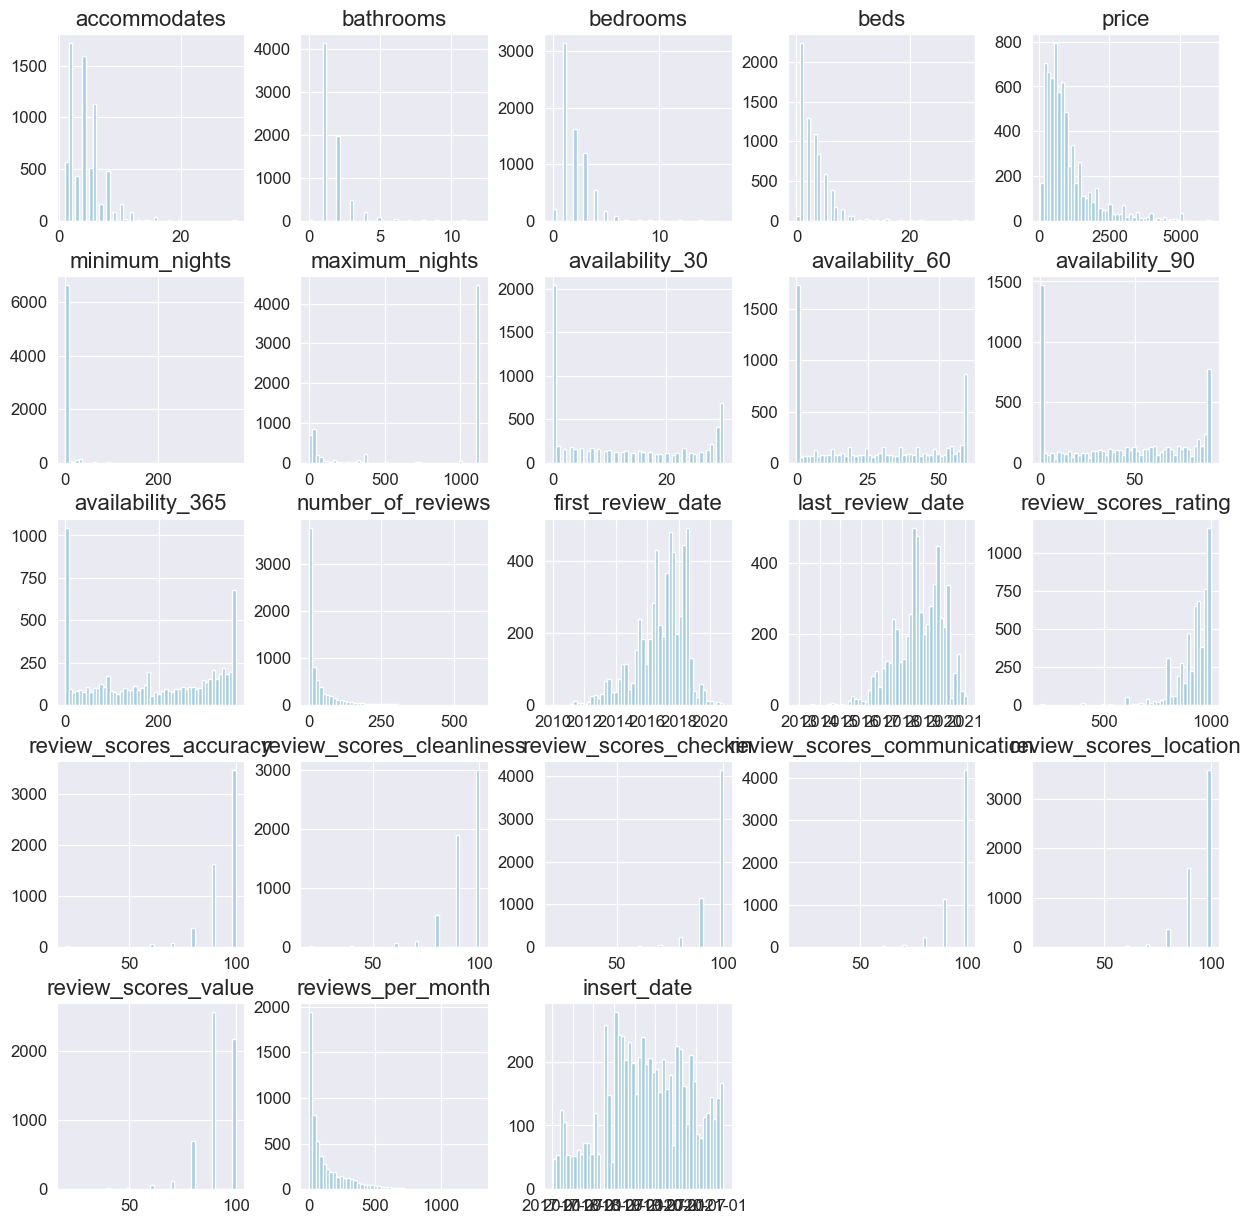

In [40]:
df.drop(['apartment_id', 'host_id'], axis=1).hist(bins=50, figsize=(15,15))
plt.show()

### Categorical variables

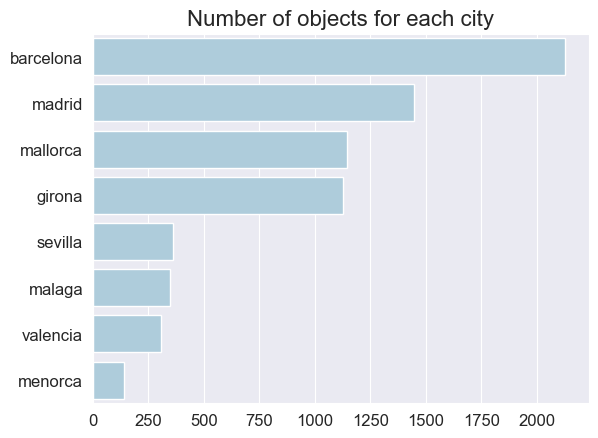

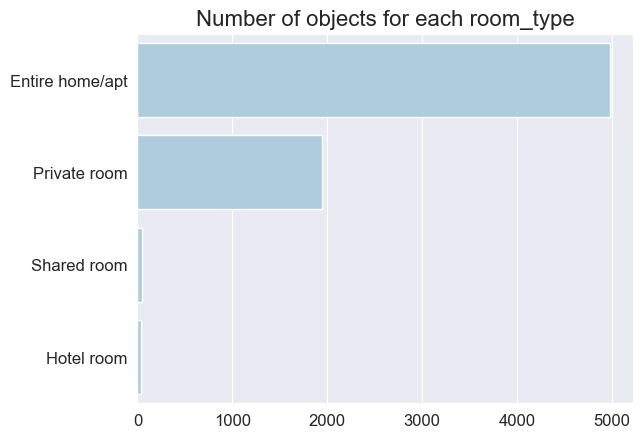

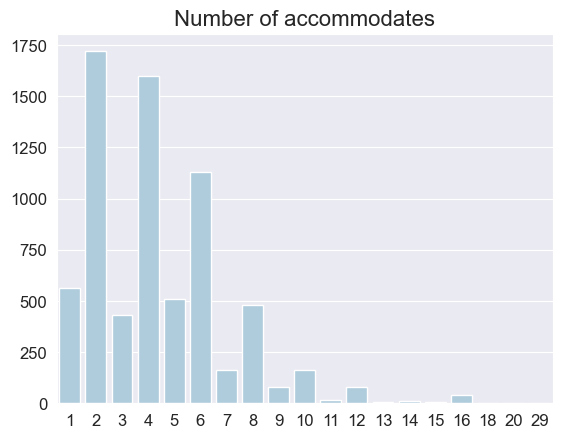

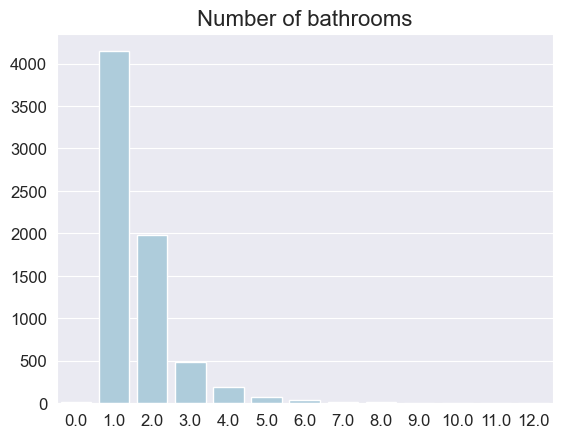

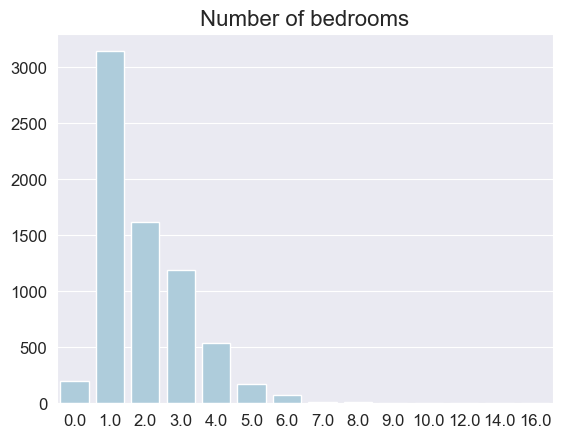

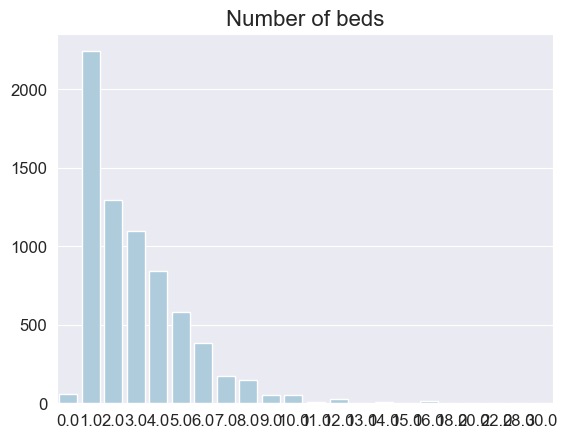

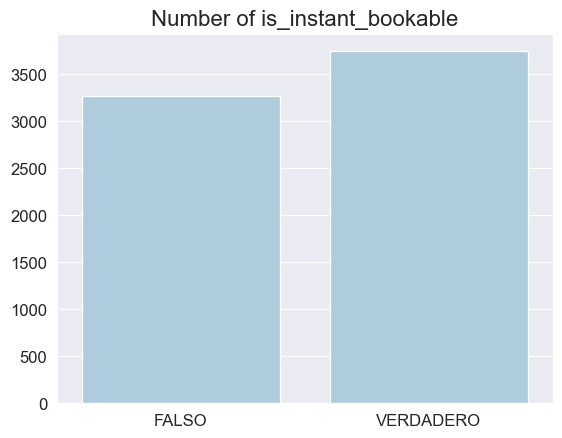

In [41]:
cat_cols = ['city', 'room_type', 'accommodates', 
            'bathrooms', 'bedrooms', 'beds',
            'is_instant_bookable']
            
for col in cat_cols:
    if col == 'city' or col == 'room_type':
        sns.countplot(data=df, y=col, order=df[col].value_counts().index)
        plt.title(f'Number of objects for each {col}')
    else:
        sns.countplot(data=df, x=col)
        plt.title(f'Number of {col}')
    plt.xlabel(None)
    plt.ylabel(None)
    plt.show()

Let's check extreme values.

In [42]:
df[df.accommodates == 29]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
3247,15883302,Ca's Misser,"Beautiful rustic farm with a total area of 21,...",102986764,Algaida,NaN,Entire home/apt,29,8.00,14.00,22.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",NaN,1,1125,VERDADERO,5,19,27,218,3,2019-05-27,2019-09-18,800.00,80.00,90.00,90.00,60.00,90.00,70.00,VERDADERO,32.00,spain,mallorca,2020-02-29


In [43]:
df[df.beds == 30]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1161,5429715,Cal Pubill de Ciuret 35pax,Cal Pubill de Ciuret �s una de les grans masie...,20320423,Vidr�,NaN,Entire home/apt,16,9.00,14.00,30.00,"TV, Indoor fireplace, Pool, Iron, Crib, Hair d...",NaN,2,1125,VERDADERO,24,54,77,296,1,2019-12-08,2019-12-08,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,9.00,spain,girona,2020-10-28


In [44]:
df[df.bathrooms == 12]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
2064,11196074,Finca can Domingo Es Trenc beach,"At the heart of the Balearic archipelago, sout...",16964951,Campos,NaN,Entire home/apt,16,12.00,10.00,16.00,"TV,Cable TV,Internet,Wifi,Air conditioning,Poo...",NaN,3,1125,VERDADERO,13,38,68,322,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,mallorca,2019-11-28


In [45]:
df[df.bedrooms == 16]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,beds,amenities_list,price,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
4588,19412149,"Mallaui, a whole palace by the sea","Do you want to live in a Mediterranean villa, ...",136087677,Ciutadella de Menorca,NaN,Entire home/apt,16,7.00,16.00,28.00,"TV,Wifi,Kitchen,Free parking on premises,Smoki...",NaN,4,30,VERDADERO,9,10,10,85,4,2018-08-10,2019-07-09,1000.00,100.00,100.00,100.00,100.00,100.00,100.00,VERDADERO,18.00,spain,menorca,2020-05-31


Data with "extreme" values looks normal.

### Numerical variables

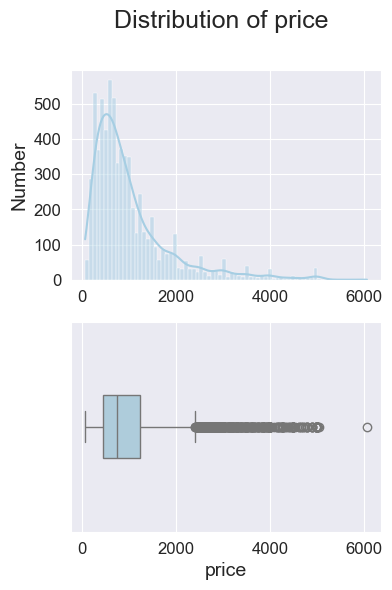

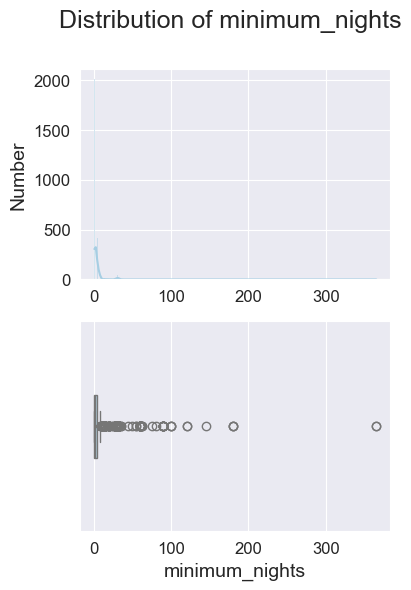

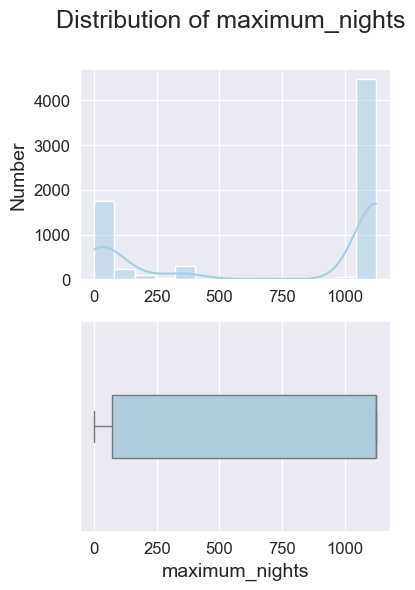

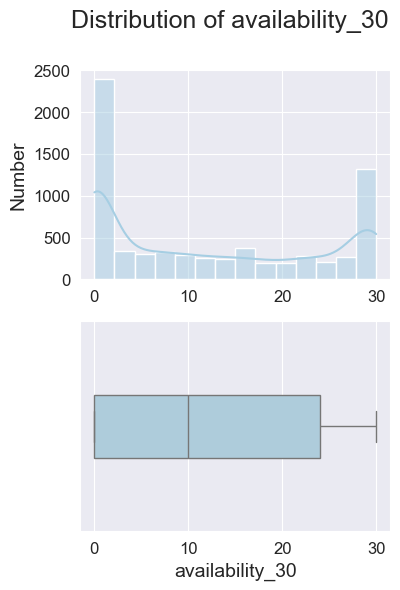

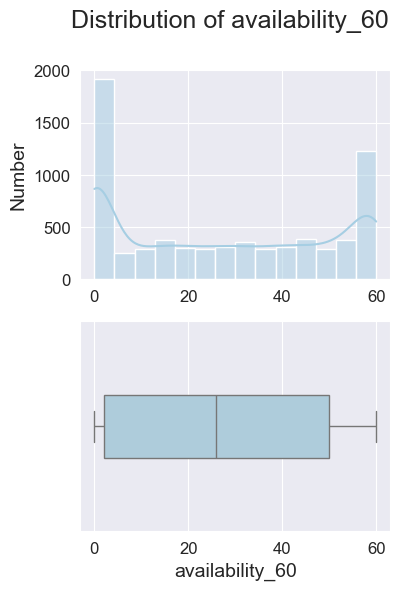

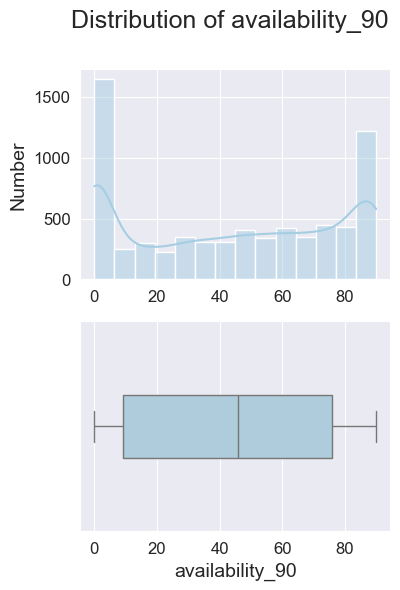

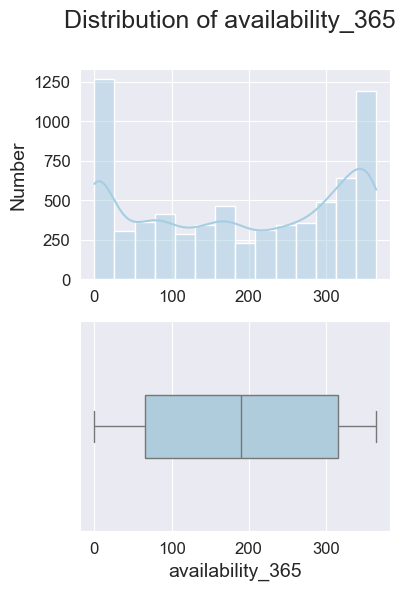

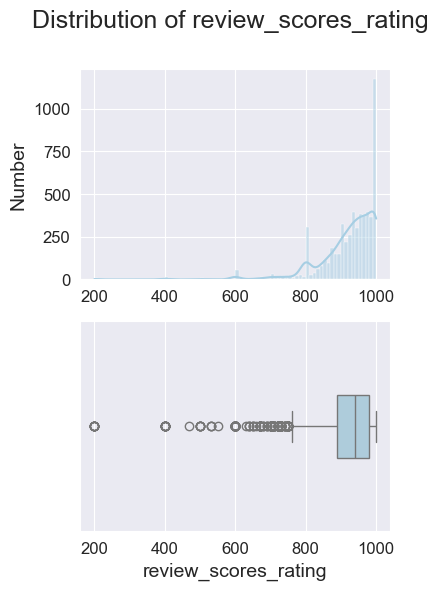

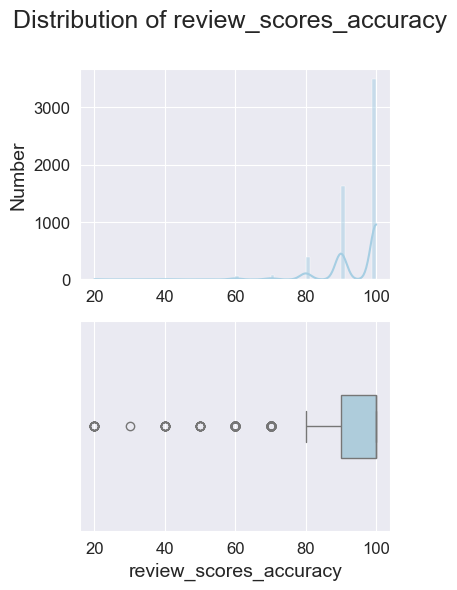

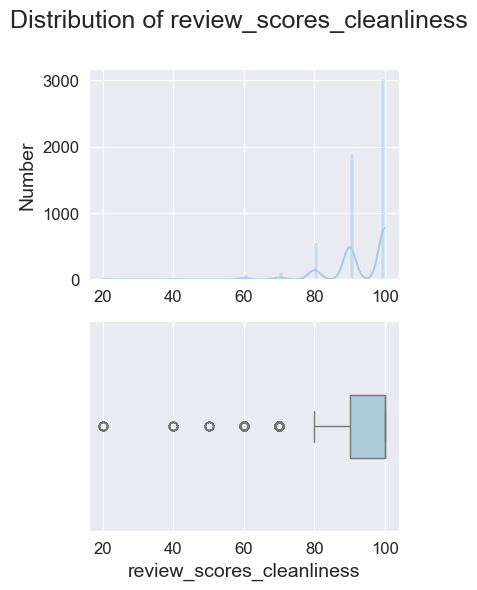

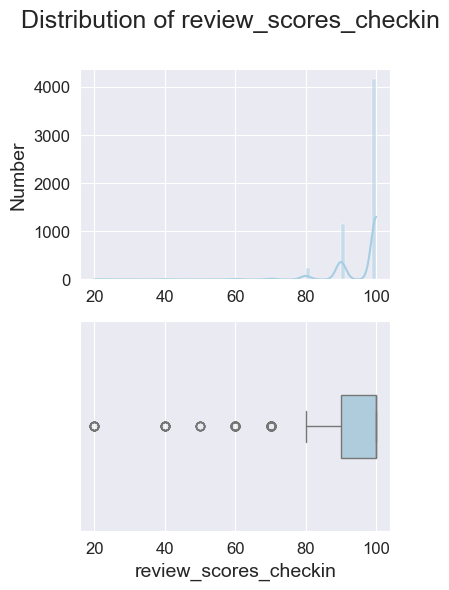

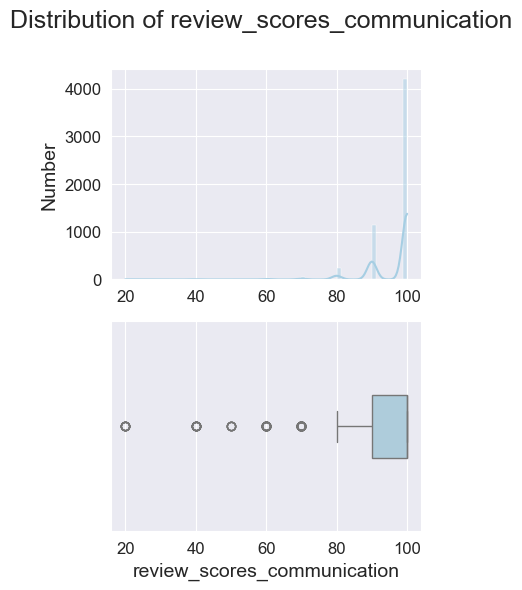

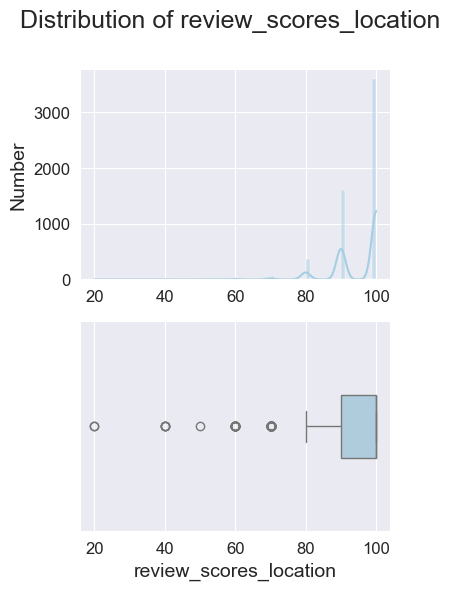

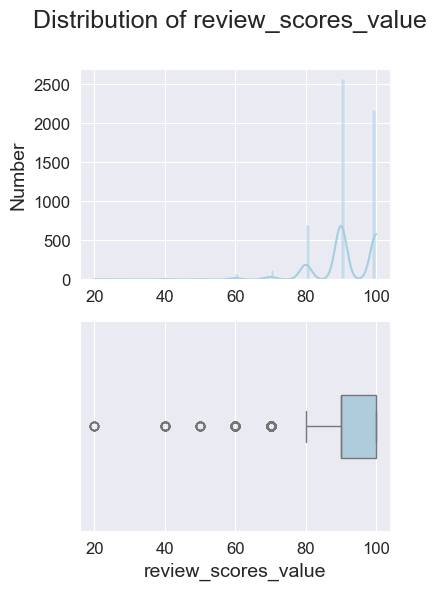

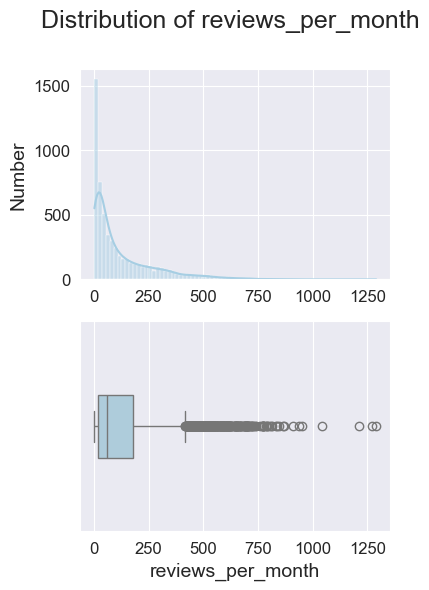

In [46]:
num_col = ['price', 'minimum_nights', 'maximum_nights',
           'availability_30', 'availability_60', 'availability_90', 'availability_365',
           'review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value', 'reviews_per_month']

for col in num_col:
    
    # visualizing the distribution of transaction amounts
    fig, axs = plt.subplots(2, 1, figsize=(4, 6))
    fig.suptitle(f"Distribution of {col}")
    
    # histogram
    (sns.histplot(data=df[col], kde=True, ax=axs[0])
        .set(xlabel=None, ylabel='Number')
    )
    
    # boxplot
    (sns.boxplot(data=df[col], ax=axs[1], width=0.3, orient='h')
        #.set(yticklabels=[], xlabel=col)
    )
    plt.show()

### Reviews

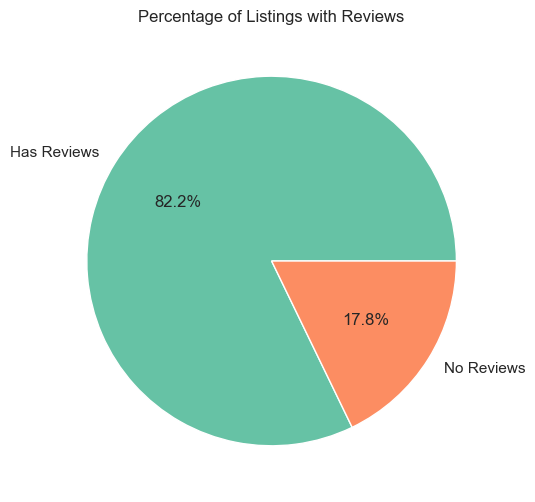

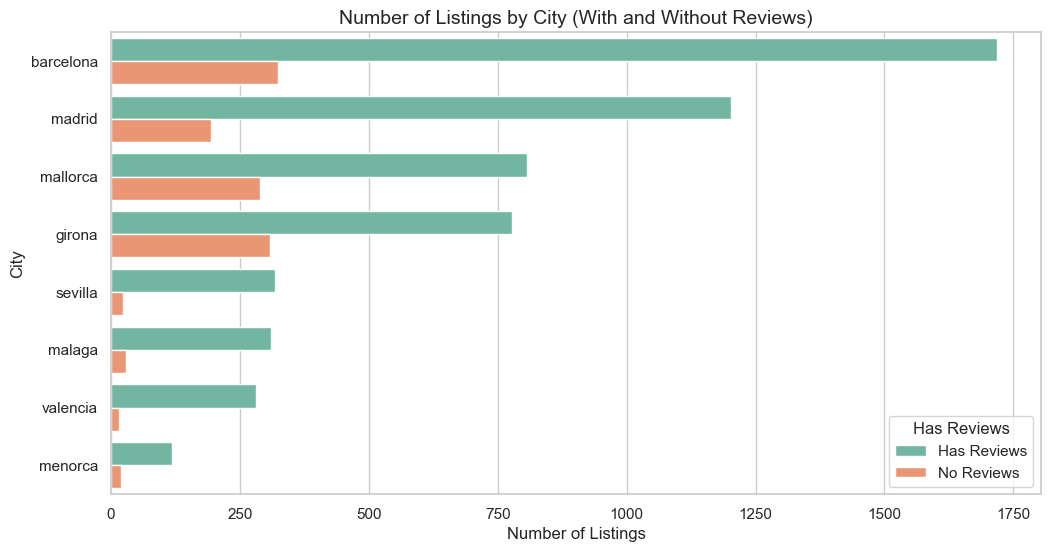

In [47]:
# Create a new column: "Has Reviews" (True/False)
df_clean['has_reviews'] = df_clean['number_of_reviews'] > 0

# Set up visualization style
sns.set_theme(style="whitegrid")

### Listings with and without reviews
plt.figure(figsize=(6, 6))
df_clean['has_reviews'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=["Has Reviews", "No Reviews"], colors=["#66c2a5", "#fc8d62"])
plt.title("Percentage of Listings with Reviews")
plt.ylabel("")
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_clean,
    y="city",
    hue="has_reviews",
    order=df_clean["city"].value_counts().index,
    hue_order=[True, False],  
    palette=["#66c2a5", "#fc8d62"] 
)

plt.title("Number of Listings by City (With and Without Reviews)", fontsize=14)
plt.xlabel("Number of Listings")
plt.ylabel("City")
plt.legend(title="Has Reviews", labels=["Has Reviews", "No Reviews"]) 
plt.show()

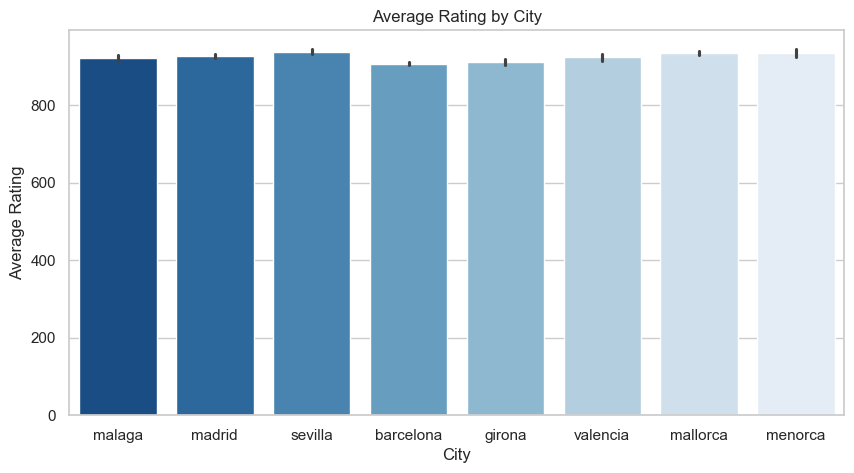

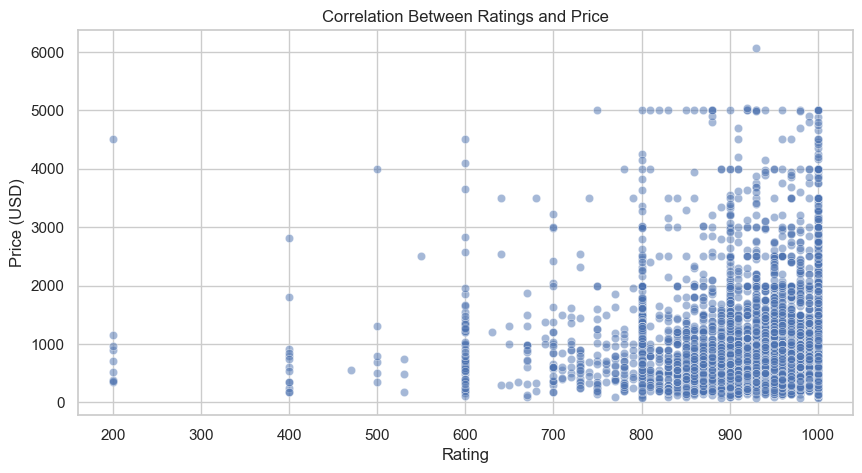

In [48]:
### Average rating by city
plt.figure(figsize=(10, 5))
sns.barplot(x='city', y='review_scores_rating', data=df_clean, estimator=lambda x: x.mean(), palette="Blues_r")
plt.title("Average Rating by City")
plt.xlabel("City")
plt.ylabel("Average Rating")
plt.show()

### Correlation between ratings and price
plt.figure(figsize=(10, 5))
sns.scatterplot(x='review_scores_rating', y='price', data=df_clean, alpha=0.5)
plt.title("Correlation Between Ratings and Price")
plt.xlabel("Rating")
plt.ylabel("Price (USD)")
plt.show()

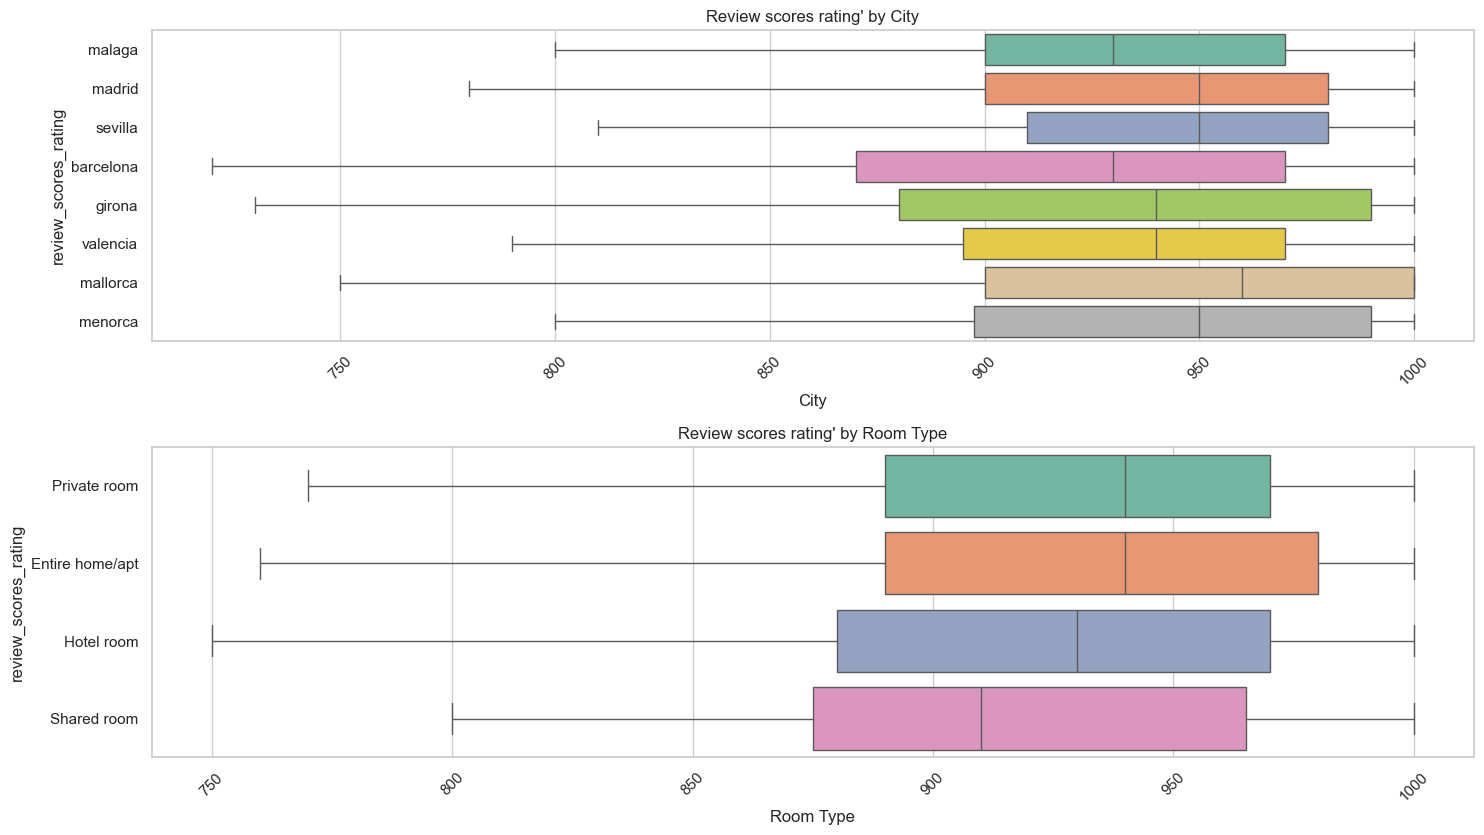

In [49]:
# Define categorical variables to analyze
categorical_vars = ["city", "room_type"]

# Set up the figure
plt.figure(figsize=(15, 12))

# Loop through each categorical variable and create a boxplot
for i, category in enumerate(categorical_vars, 1):
    plt.subplot(3, 1, i)  # Create subplots (3 rows, 1 column)
    sns.boxplot(x='review_scores_rating', y=category, data=df_clean, showfliers=False, palette="Set2")
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.title(f"Review scores rating' by {category.replace('_', ' ').title()}")
    plt.xlabel(category.replace('_', ' ').title())
    plt.ylabel("review_scores_rating")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Save Clean Dataframe

In [50]:
#df_clean.to_csv(f'../Data/data_clean_sprint_{SPRINT}.csv', index=False)
df_clean.to_csv(f'../Data/data_clean_latest.csv', index=False) 